# U-net 구현 및 실습

## 논문에 나오는 구조

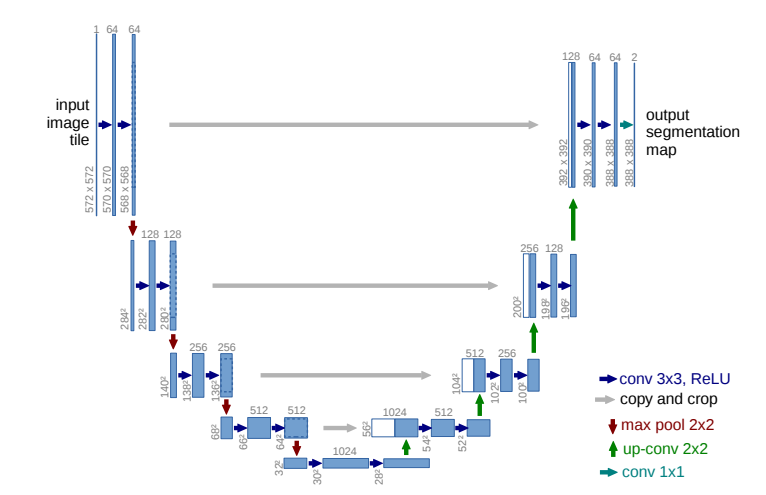

## 논문을 기반으로 네트워크 구현

In [1]:
import argparse

import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets

`+` CNN output size 계산


$ outputsize = \frac{Inputsize - Kernel + 2Padding}{Stride} + 1$

- 아래에서 정의하는 `CBR2d`를 위 식에 적용해보면 outputsize = inputsize인 것을 알 수 있음
- 이미지의 사이즈는 maxpooling을 사용하여 Width와 Height를 절반씩 줄여주는 것을 확인할 수 있음

In [ ]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size =3, stride = 1, padding = 1, bias = True): #convolution + bathnormalization + Relu
            layers = []
            layers = layers + [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                          kernel_size=kernel_size, stride=stride, padding= padding,
                                          bias=bias)]
            layers = layers + [nn.BatchNorm2d(num_features = out_channels)]
            layers = layers + [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr
        
        # contracting(encoder)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        ## Expansive (decoder)
        self.dec5_2 = CBR2d(in_channels=1024, out_channels=512)
        
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, 
                                          kernel_size=2, stride=2, padding= 0,bias=True)
        
        self.dec4_2 = CBR2d(in_channels= 2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)
        
        self.unpool3 = nn.ConvTranspose2d(in_channels= 256, out_channels=256, 
                                          kernel_size=2, stride=2, padding= 0,bias=True)
        
        self.dec3_2 = CBR2d(in_channels= 2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels= 128, out_channels=128, 
                                          kernel_size=2, stride=2, padding= 0,bias=True)
        
        self.dec2_2 = CBR2d(in_channels= 2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels= 64, out_channels=64, 
                                          kernel_size=2, stride=2, padding= 0,bias=True)
        
        self.dec1_2 = CBR2d(in_channels= 2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1,stride=1, padding = 0, bias = True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

### 함수 설명

##### 1. torch.nn.ConvTranspose2d() : upsampling시 사용하는 함수

- 사용 예시
```python
self.unpool1 = nn.ConvTranspose2d(in_channels= 64, out_channels=64, kernel_size=2, stride=2, padding= 0,bias=True)
```

https://cumulu-s.tistory.com/29


#### 2. torch.cat() : skip connection을 구현할 때 사용
    - dim = 1로 지정하면 채널을 기준으로 concat  
    - dim = 0일 때 -> batch를 기준으로
    - dim = 2일 때 -> height를 기준으로
    - dim = 3일 떄 -> width를 기준으로

In [18]:
a = torch.tensor([[[[1,2,3,4],[5,6,7,8],[9,10,11,12]]]])
b = torch.tensor([[[[1,2,3,4],[5,6,7,8],[9,10,11,12]]]])
print(a)

tensor([[[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12]]]])


In [17]:
test_dim0 = torch.cat((a,b),dim = 0)
print("dim = 0일 때: \n",test_dim0, '\n', test_dim0.shape)

dim = 0일 때: 
 tensor([[[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12]]],


        [[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12]]]]) 
 torch.Size([2, 1, 3, 4])


In [14]:
test_dim1 = torch.cat((a,b),dim = 1)
print("dim = 1일 때: \n",test_dim1, '\n', test_dim1.shape)

dim = 1일 때: 
 tensor([[[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12]],

         [[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12]]]]) 
 torch.Size([1, 2, 3, 4])


In [15]:
test_dim2 = torch.cat((a,b),dim = 2)
print("dim = 2일 때: \n",test_dim2, '\n', test_dim2.shape)

dim = 2일 때: 
 tensor([[[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12]]]]) 
 torch.Size([1, 1, 6, 4])


In [16]:
test_dim3 = torch.cat((a,b),dim = 3)
print("dim = 3일 때: \n",test_dim3, '\n', test_dim3.shape)

dim = 3일 때: 
 tensor([[[[ 1,  2,  3,  4,  1,  2,  3,  4],
          [ 5,  6,  7,  8,  5,  6,  7,  8],
          [ 9, 10, 11, 12,  9, 10, 11, 12]]]]) 
 torch.Size([1, 1, 3, 8])


## 결과

`-` loss 곡선

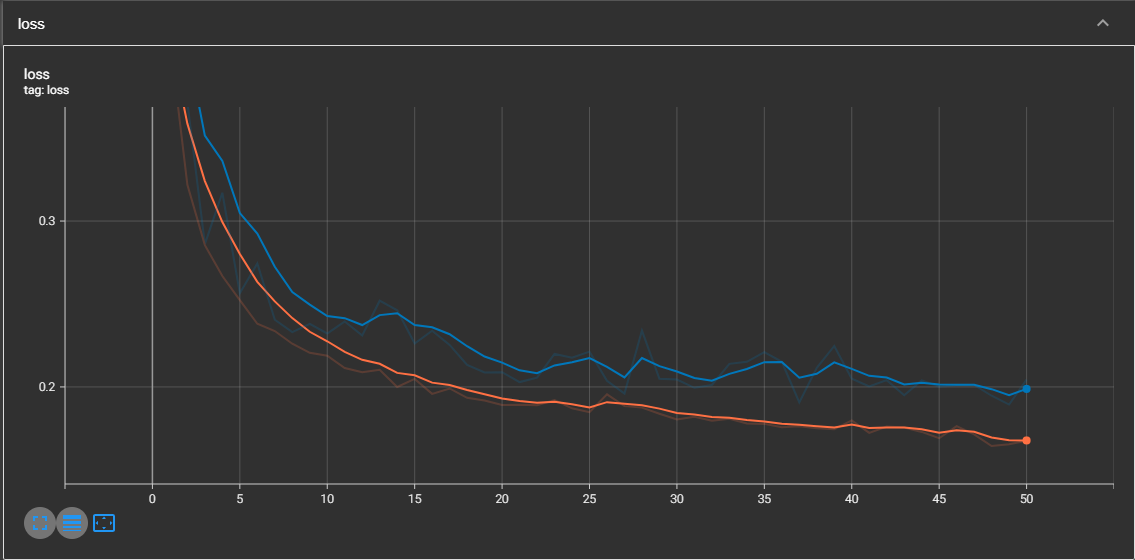

`-` 만들어진 annotation  
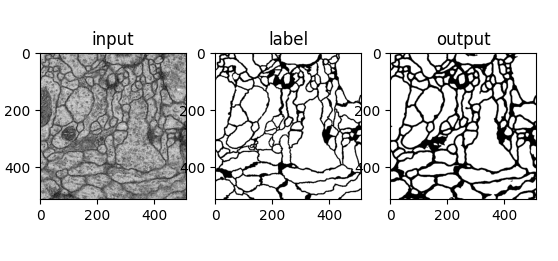  
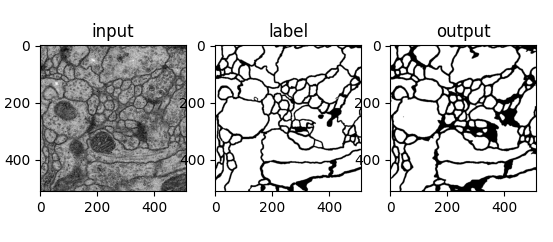  
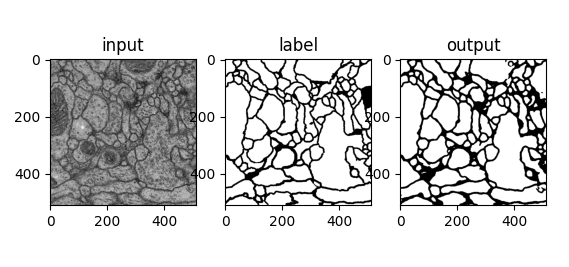

## (참고) U-net 훈련을 위한 .py 파일

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

## 트레이닝 파라미터 설정
lr = 1e-3
batch_size = 2
num_epoch = 50

data_dir = './datasets'
ckpt_dir = './checkpoint'
log_dir = './log'


##
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        label = label/255.0
        input = input/255.0

        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        if self.transform:
            data = self.transform(data)

        return data
##
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}
        return data

class Normalization(object):
    def __init__(self, mean = 0.5, std = 0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std
        data = {'label': label, 'input': input}

        return data


class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

## 네트워크 학습하기
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 네트워크 생성하기
net = UNet().to(device)

fn_loss = nn.BCEWithLogitsLoss().to(device)
optim = torch.optim.Adam(net.parameters(),lr=lr)

num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

## function
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_clss = lambda x: 1.0*(x>0.5)

## tensorboard를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

## 네트워크 학습시키기
st_epoch = 0

## 네트워크 저장하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))


## 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

#net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

for epoch in range(st_epoch + 1, num_epoch + 1):
    net.train()
    loss_arr = []

    for batch, data in enumerate(loader_train, 1):
        # forward pass
        label = data['label'].to(device)
        input = data['input'].to(device)

        output = net(input)

        # backward pass
        optim.zero_grad()

        loss = fn_loss(output, label)
        loss.backward()

        optim.step()

        # 손실함수 계산
        loss_arr += [loss.item()]

        print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
              (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

        # Tensorboard 저장하기
        label = fn_tonumpy(label)
        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_clss(output))

        writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

    with torch.no_grad():
        net.eval()
        loss_arr = []

        for batch, data in enumerate(loader_val, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # 손실함수 계산하기
            loss = fn_loss(output, label)

            loss_arr += [loss.item()]

            print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_clss(output))

            writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

    writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

    if epoch % 50 == 0:
        save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)

writer_train.close()
writer_val.close()
